In [1]:
import glob
import os
import collections

import pickle
import sys
import glob
from pathlib import Path, PurePath
path = Path.cwd()
parent_path = path.parents[1]
sys.path.append(str(PurePath(parent_path, 'neuroformer')))
sys.path.append('neuroformer')
sys.path.append('.')
sys.path.append('../')


import pandas as pd
import numpy as np
from einops import rearrange

from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
import pandas as pd
from torch.utils.data.dataloader import DataLoader

import math
from torch.utils.data import Dataset

from trainer import Trainer, TrainerConfig
from utils import set_seed


from scipy import io as scipyio
from scipy.special import softmax
import skimage
import skvideo.io
from utils import print_full
from scipy.ndimage import gaussian_filter, uniform_filter


import matplotlib.pyplot as plt
from utils import *
from visualize import *
set_plot_params()
parent_path = os.path.dirname(os.path.dirname(os.getcwd())) + "/"


from model_neuroformer import GPT, GPTConfig, neuralGPTConfig, Decoder
from trainer import Trainer, TrainerConfig


import json
# for i in {1..10}; do python3 -m gather_atts.py; done


/opt/conda/envs/neuroformer/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/conda/envs/neuroformer/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libjpeg.so.8: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [2]:
# set os cuda device
os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [3]:
DATASET = 'LRL2'

from neuroformer.prepare_data import load_LRN, load_LRL2

if DATASET == 'LRL2':
    df, stimulus = load_LRL2()
else:
    df, stimulus = load_LRN()


In [4]:
# set up logging
import logging
logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        level=logging.INFO,
)


In [5]:
from utils import set_seed
n_seed = 25
set_seed(n_seed)


In [6]:
# load config files

import yaml

base_path = "./models/tensorboard/LRN/channel/window:0.5_prev:19.5_smooth/sparse_f:None_id:None/w:0.5_wp:19.5"

with open(os.path.join(base_path, 'mconf.yaml'), 'r') as stream:
    mconf = yaml.full_load(stream)

with open(os.path.join(base_path, 'tconf.yaml'), 'r') as stream:
    tconf = yaml.full_load(stream)

with open(os.path.join(base_path, 'dconf.yaml'), 'r') as stream:
    dconf = yaml.full_load(stream)

import omegaconf
from omegaconf import OmegaConf

# open yaml as omegacong
mconf = OmegaConf.create(mconf)
tconf = OmegaConf.create(tconf)
dconf = OmegaConf.create(dconf)


In [7]:
# df = pd.read_csv(parent_path + "code/data/OneCombo3/Combo3_all_stim.csv")
w_mult = 3
frame_window = dconf.frame_window
window = dconf.window
window_prev = dconf.window_prev
dt = dconf.dt
dt_frames = dconf.dt_frames
# p_window = window / (window + window_prev)
# intervals = np.load(os.path.join(base_path, "intervals.npy"))
intervals = None


from SpikeVidUtils import make_intervals

df['real_interval'] = make_intervals(df, dt)
df['Interval'] = make_intervals(df, window)
df['Interval_2'] = make_intervals(df, window_prev)
df = df.reset_index(drop=True)

# n_dt = sorted((df['Interval_dt'].unique()).round(2)) 
max_window = max(window, window_prev)
dt_range = math.ceil(max_window / dt) + 1  # add first / last interval for SOS / EOS'
n_dt = [round(dt * n, 2) for n in range(dt_range)] + ['EOS'] + ['PAD']


In [8]:
# int_trials = df.groupby(['Interval', 'Trial']).size()
# print(int_trials.mean())
# df.groupby(['Interval', 'Trial']).agg(['nunique'])model_path
# var_group = 'Interval_2'
# n_unique = len(df.groupby([var_group, 'Trial']).size())
# df.groupby([var_group, 'Trial']).size().nlargest(int(0.2 * n_unique))
# df.groupby(['Interval_2', 'Trial']).size().mean()



In [9]:
from SpikeVidUtils import SpikeTimeVidData2

## resnet3d feats
n_embd = mconf.n_embd
frame_feats = torch.tensor(stimulus, dtype=torch.float32).transpose(1, 0)
frame_block_size = mconf.frame_block_size  # math.ceil(frame_feats.shape[-1] * frame_window)
n_embd_frames = mconf.n_embd_frames

prev_id_block_size = mconf.prev_id_block_size    # math.ceil(frame_block_size * (1 - p_window))
id_block_size = mconf.id_block_size           # math.ceil(frame_block_size * p_window)
block_size = frame_block_size + id_block_size + prev_id_block_size # frame_block_size * 2  # small window for faster training
frame_memory = dconf.frame_memory   # how many frames back does model see

neurons = sorted(list(set(df['ID'])))
id_stoi = { ch:i for i,ch in enumerate(neurons) }
id_itos = { i:ch for i,ch in enumerate(neurons) }

# translate neural embeddings to separate them from ID embeddings
neurons = sorted(list(set(df['ID'].unique())))
trial_tokens = [f"Trial {n}" for n in df['Trial'].unique()]
feat_encodings = neurons + ['SOS'] + ['EOS'] + ['PAD']  # + pixels 
stoi = { ch:i for i,ch in enumerate(feat_encodings) }
itos = { i:ch for i,ch in enumerate(feat_encodings) }
stoi_dt = { ch:i for i,ch in enumerate(n_dt) }
itos_dt = { i:ch for i,ch in enumerate(n_dt) }



In [10]:
r_split = 0.8
train_trials = sorted(df['Trial'].unique())[:int(len(df['Trial'].unique()) * r_split)]
train_data = df[df['Trial'].isin(train_trials)]
test_data = df[~df['Trial'].isin(train_trials)]




In [11]:
from SpikeVidUtils import SpikeTimeVidData2

# train_dat1aset = spikeTimeData(spikes, block_size, dt, stoi, itos)


train_dataset = SpikeTimeVidData2(train_data, None, block_size, id_block_size, frame_block_size, prev_id_block_size, 
                                  window, dt, frame_memory, stoi, itos, neurons, stoi_dt, itos_dt, frame_feats,
                                  pred=False, window_prev=window_prev, frame_window=frame_window,
                                  dt_frames=dt_frames, intervals=intervals, dataset=mconf.dataset)
test_dataset = SpikeTimeVidData2(test_data, None, block_size, id_block_size, frame_block_size, prev_id_block_size, 
                                 window, dt, frame_memory, stoi, itos, neurons, stoi_dt, itos_dt, frame_feats, 
                                 pred=False, window_prev=window_prev, frame_window=frame_window,
                                 dt_frames=dt_frames, intervals=intervals, dataset=mconf.dataset)

print(f'train: {len(train_dataset)}, test: {len(test_dataset)}')


Length: 4819760 Neurons: 1003 Pixels: 0.
id block size: 150
frames: 200, id: 150
Length: 1197034 Neurons: 1003 Pixels: 0.
id block size: 150
frames: 200, id: 150
train: 1417367, test: 354272


In [12]:
# from utils import get_class_weights
# class_weights = get_class_weights(train_dataset, stoi, stoi_dt)


In [13]:
from model_neuroformer_LRN import GPT, GPTConfig
# initialize config class and model (holds hyperparameters)
   
conv_layer = False
model_conf = GPTConfig(train_dataset.population_size, block_size,    # frame_block_size
                        id_vocab_size=train_dataset.id_population_size,
                        frame_block_size=frame_block_size,
                        id_block_size=id_block_size,  # frame_block_size
                        prev_id_block_size=prev_id_block_size,
                        sparse_mask=False, p_sparse=0.25, 
                        sparse_topk_frame=None, sparse_topk_id=None, sparse_topk_prev_id=None,
                        n_dt=len(n_dt),
                        data_size=train_dataset.size,
                        class_weights=None,
                        pretrain=False,
                        n_state_layers=mconf.n_state_layers, n_state_history_layers=mconf.n_state_history_layers,
                        n_stimulus_layers=mconf.n_stimulus_layers, self_att_layers=mconf.self_att_layers,
                        n_head=mconf.n_head, n_embd=mconf.n_embd, 
                        contrastive=True, clip_emb=1024, clip_temp=0.5,
                        temp_emb=True, pos_emb=False,
                        id_drop=0.35, im_drop=0.35,
                        window=window, window_prev=window_prev, frame_window=frame_window, dt=dt,
                        neurons=neurons, stoi_dt=stoi_dt, itos_dt=itos_dt, n_embd_frames=n_embd_frames,
                        ignore_index_id=stoi['PAD'], ignore_index_dt=stoi_dt['PAD'])  # 0.35

for k, v in model_conf.__dict__.items():
    if hasattr(mconf, k):
        mconf.k = v

# mconf.contrastive = False
model = GPT(mconf).cpu()

51200


02/21/2023 00:35:29 - INFO - model_neuroformer_LRN -   number of parameters: 1.303196e+08


In [14]:
layers = (mconf.n_state_layers, mconf.n_state_history_layers, mconf.n_stimulus_layers)
max_epochs = 300
batch_size = round((14))
shuffle = True

weighted = True if mconf.class_weights is not None else False
title =  f'window:{window}_prev:{window_prev}_smooth'
model_path = f"""./models/tensorboard/LRN/ignore_index/2_{title}/sparse_f:{mconf.sparse_topk_frame}_id:{mconf.sparse_topk_id}/w:{window}_wp:{window_prev}/{6}_Cont:{mconf.contrastive}_window:{window}_f_window:{frame_window}_df:{dt}_blocksize:{id_block_size}_conv_{conv_layer}_shuffle:{shuffle}_batch:{batch_size}_sparse_({mconf.sparse_topk_frame}_{mconf.sparse_topk_id})_blocksz{block_size}_pos_emb:{mconf.pos_emb}_temp_emb:{mconf.temp_emb}_drop:{mconf.id_drop}_dt:{shuffle}_2.0_{max(stoi_dt.values())}_max{dt}_{layers}_{mconf.n_head}_{mconf.n_embd}.pt"""

# model_path = "/data5/antonis/neuroformer/models/tensorboard/LRN/channel/window:0.5_prev:19.5_smooth/sparse_f:None_id:None/w:0.5_wp:19.5/6_Cont:True_window:0.5_f_window:20_df:0.1_blocksize:150_conv_False_shuffle:True_batch:12_sparse_(None_None)_blocksz1150_pos_emb:False_temp_emb:True_drop:0.35_dt:True_2.0_197_max0.1_(8, 8, 8)_8_256.pt"
# if os.path.exists(model_path):
#     print(f"Loading model from {model_path}")
#     model.load_state_dict(torch.load(model_path))
# else:
#     print(f"Model not found at {model_path}")
#     raise FileNotFoundError

tconf = TrainerConfig(max_epochs=max_epochs, batch_size=batch_size, learning_rate=1e-4, 
                    num_workers=4, lr_decay=False, patience=3, warmup_tokens=8e7, 
                    decay_weights=True, weight_decay=0.2, shuffle=shuffle,
                    final_tokens=len(train_dataset)*(id_block_size) * (max_epochs),
                    clip_norm=1.0, grad_norm_clip=1.0,
                    dataset='higher_order', mode='predict',
                    block_size=train_dataset.block_size,
                    id_block_size=train_dataset.id_block_size,
                    show_grads=False, plot_raster=False,
                    ckpt_path=model_path, no_pbar=False, 
                    dist=True, save_every=1000)

# trainer = Trainer(model, train_dataset, test_dataset, tconf, mconf)
# trainer.train()


In [15]:
loader = DataLoader(train_dataset, batch_size=32, shuffle=shuffle, num_workers=4, pin_memory=True)
iterable = iter(loader)



In [16]:
x, y = next(iterable)


In [17]:
_, _, _, = model(x, y)

In [18]:
"""

RUN SIMULATION

"""

from utils import *
from IPython.utils import io
# top_p=0.25, top_p_t=0.9, temp=2.

model_weights = glob.glob(os.path.join(base_path, '**/**.pt'), recursive=True)
model_weights = sorted(model_weights, key=os.path.getmtime, reverse=True)
assert len(model_weights) > 0, "No model weights found"

if model_path in model_weights:
    load_weights = model_path
else:
    load_weights = model_weights[0]

model.load_state_dict(torch.load(load_weights, map_location=torch.device('cpu')))


<All keys matched successfully>

In [19]:
df

,Time,ID,Trial,real_interval,Interval,Interval_2
0,4.6,50,1,4.6,5.0,19.5
1,4.7,112,1,4.7,5.0,19.5
2,5.0,460,1,5.0,5.0,19.5
3,5.1,206,1,5.1,5.5,19.5
4,5.2,645,1,5.2,5.5,19.5
...,...,...,...,...,...,...
6016789,9997.1,787,100,9997.1,9997.5,10003.5
6016790,9997.2,494,100,9997.2,9997.5,10003.5
6016791,9998.3,254,100,9998.3,9998.5,10003.5
6016792,9998.9,786,100,9998.9,9999.0,10003.5


In [20]:
from utils import predict_raster_recursive_time_auto

trials = test_data['Trial'].unique()[:4]
results_dict = dict()
df_pred = None
df_true = None

top_p = 0.75
top_p_t = 0.75
temp = 1.2
temp_t = 1.2

for trial in trials:    # test_data['Trial'].unique():
    # with io.capture_output() as captured:
        print(f"Trial: {trial}")
        df_trial = df[df['Trial'] == trial]
        df_trial = df_trial[df_trial['Interval'] < 200]
        trial_dataset = SpikeTimeVidData2(df_trial,  None, block_size, id_block_size, frame_block_size, prev_id_block_size, 
                                  window, dt, frame_memory, stoi, itos, neurons, stoi_dt, itos_dt, frame_feats, 
                                  pred=False, window_prev=window_prev, frame_window=frame_window, start_interval=20,
                                  dt_frames=dt_frames, dataset=mconf.dataset)
        trial_loader = DataLoader(trial_dataset, shuffle=False, pin_memory=False)
        results_trial = predict_raster_recursive_time_auto(model, trial_dataset, window, window_prev, stoi, itos_dt, itos=itos, 
                                                           sample=True, top_p=top_p, top_p_t=top_p_t, temp=temp, temp_t=temp_t, 
                                                           frame_end=0, get_dt=True, gpu=False, pred_dt=True)
        # results_trial = predict_raster_hungarian(model, loader, itos_dt, top_p=0.75, temp=1)
        # print(f"MAX ID ---- {sorted(results_trial['ID'].unique()[-10])}")
        df_trial_pred, df_trial_true = process_predictions(results_trial, stoi, itos, window)
        print(f"pred: {df_trial_pred.shape}, true: {df_trial_true.shape}" )
        if df_pred is None:
            df_pred = df_trial_pred
            df_true = df_trial_true
        else:
            df_pred = pd.concat([df_pred, df_trial_pred])
            df_true = pd.concat([df_true, df_trial_true])


from analysis import compute_scores
scores = compute_scores(df[df['Trial'].isin(trials)], df_pred)
print(scores)
print(f"pred: {len(df_pred)}, true: {len(df_true)}" )


Trial: 81
Length: 1447 Neurons: 1003 Pixels: 0.
id block size: 150
frames: 200, id: 150


len pred: 530, len true: 1590: 100%|██████████| 323/323 [01:30<00:00,  3.59it/s]


SOS fouuuund: 0
EOS fouuuund: 323
pred: (525, 5), true: (1267, 2)
Trial: 82
Length: 983 Neurons: 1003 Pixels: 0.
id block size: 150
frames: 200, id: 150


len pred: 242, len true: 1168: 100%|██████████| 316/316 [00:58<00:00,  5.40it/s]


SOS fouuuund: 0
EOS fouuuund: 316
pred: (241, 5), true: (852, 2)
Trial: 83
Length: 1355 Neurons: 1003 Pixels: 0.
id block size: 150
frames: 200, id: 150


len pred: 520, len true: 1433: 100%|██████████| 324/324 [01:29<00:00,  3.63it/s]


SOS fouuuund: 0
EOS fouuuund: 324
pred: (508, 5), true: (1109, 2)
Trial: 84
Length: 1010 Neurons: 1003 Pixels: 0.
id block size: 150
frames: 200, id: 150


len pred: 250, len true: 1186: 100%|██████████| 324/324 [01:03<00:00,  5.14it/s]


SOS fouuuund: 0
EOS fouuuund: 324
pred: (246, 5), true: (862, 2)
defaultdict(<class 'list'>, {'precision': 0.0059992892944838025, 'recall': 0.005571262867913585, 'F1': 0.0055983416296775095})
pred: 1520, true: 4090


In [21]:
from SpikeVidUtils import set_intevals
from analysis import get_rates_trial, calc_corr_psth

df_3 = df[df['Trial'].isin(trials + 2)]
df_1 = df[df['Trial'].isin(trials)]
df_2 = df[df['Trial'].isin(trials + 1)]

df_pred_full = df_pred
df_list = [df_pred_full, df_1, df_2, df_3]

window_pred = 20
min_window = df_pred_full['Interval'].min()
max_window = df_pred_full['Interval'].max()
df_pred_full = set_intevals(df_pred_full, window, window_prev, max_window, window_pred, min_window)
df_1 = set_intevals(df_1, window, window_prev, max_window, window_pred, min_window)
df_2 = set_intevals(df_2, window, window_prev, max_window, window_pred, min_window)
df_3 = set_intevals(df_3, window, window_prev, max_window, window_pred, min_window)

window_pred = window if window_pred is None else window_pred
# intervals = np.array(sorted(set(df['Interval'].unique()) & set(df['Interval'].unique())))
labels = np.array([round(window_pred + window_pred*n, 2) for n in range(0, int(max(df_pred_full['Interval']) / window_pred))])
ids = sorted(set(df['ID'].unique()) & set(df['ID'].unique()))

# labels = sorted(set(df_pred_full['Interval'].unique()))
rates_pred = get_rates_trial(df_pred_full, labels)
rates_1 = get_rates_trial(df_1, labels)
rates_2 = get_rates_trial(df_2, labels)
rates_3 = get_rates_trial(df_3, labels)

top_corr_pred = calc_corr_psth(rates_pred, rates_1)
top_corr_real = calc_corr_psth(rates_1, rates_2)
top_corr_real_2 = calc_corr_psth(rates_1, rates_3)


id_pred: 520, id_true_1: 851, id_true_2: 801
len_pred: 1514, len_true: 4158
real: defaultdict(<class 'list'>, {'precision': 0.75, 'recall': 0.75, 'F1': 0.75})
pred: defaultdict(<class 'list'>, {'precision': 0.11097683122321643, 'recall': 0.04788368190559355, 'F1': 0.06179436045915479})


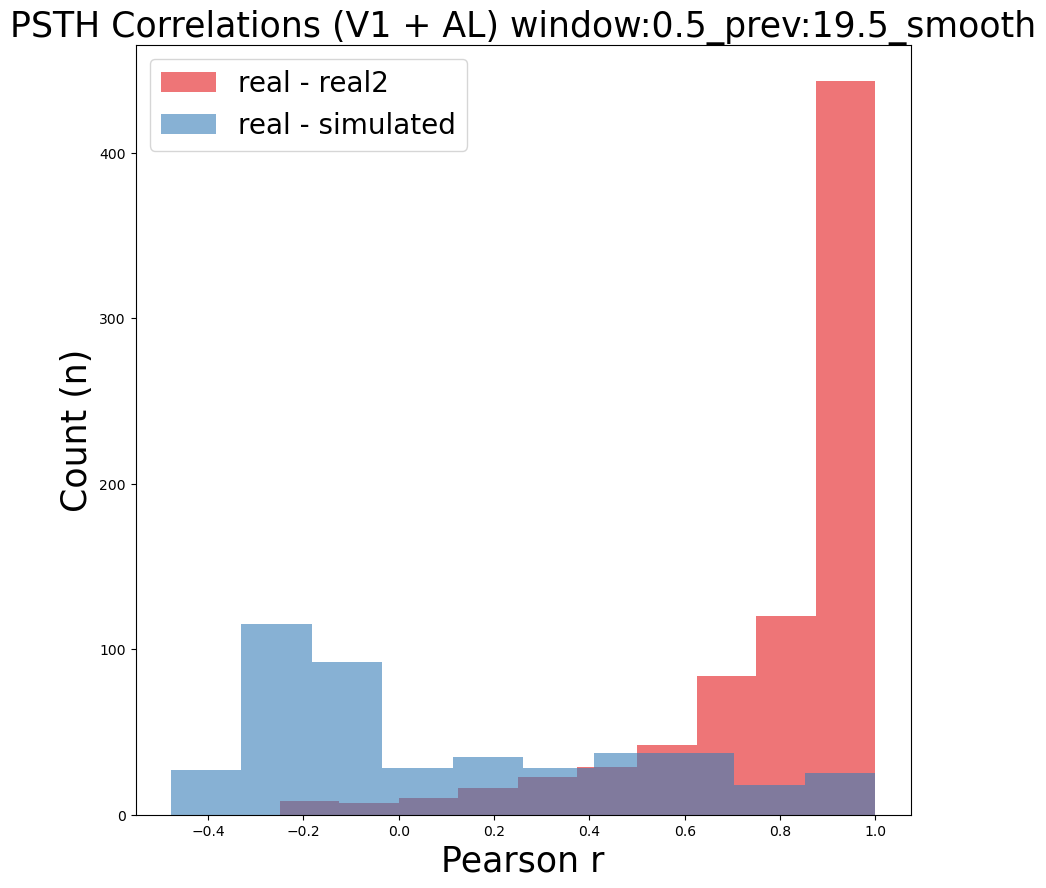

FileNotFoundError: [Errno 2] No such file or directory: './models/tensorboard/LRN/ignore_index/2_window:0.5_prev:19.5_smooth/sparse_f:None_id:None/w:0.5_wp:19.5/psth_corr_window:0.5_prev:19.5_smooth_top_p0.75_.svg'

<Figure size 640x480 with 0 Axes>

In [22]:
"""

Evaluate results

"""

from visualize import *

# df_2['Trial'] -= 2
id_pred, id_true_1, id_true_2 = len(df_pred_full['ID'].unique()), len(df_1['ID'].unique()), len(df_2['ID'].unique())
print(f"id_pred: {id_pred}, id_true_1: {id_true_1}, id_true_2: {id_true_2}")

len_pred, len_true = len(df_pred_full), len(df_1)
print(f"len_pred: {len_pred}, len_true: {len_true}")

accuracy = get_accuracy(df_pred, df_2)

scores = compute_scores(df_1, df_2)
pred_scores = compute_scores(df_1, df_pred_full)
print(f"real: {scores}")
print(f"pred: {pred_scores}")

set_plot_white()
plt.figure(figsize=(10, 10), facecolor='white')
plt.title(f'PSTH Correlations (V1 + AL) {title}', fontsize=25)
plt.ylabel('Count (n)', fontsize=25)
plt.xlabel('Pearson r', fontsize=25)
plt.hist(top_corr_real, label='real - real2', alpha=0.6)
# plt.hist(top_corr_real_2, label='real - real3', alpha=0.6)
plt.hist(top_corr_pred, label='real - simulated', alpha=0.6)
plt.legend(fontsize=20)
plt.show()

dir_name = os.path.dirname(model_path)
model_name = os.path.basename(model_path)

plot_title = title + f'_top_p{top_p}'
plt.savefig(os.path.join(dir_name, F'psth_corr_{plot_title}_.svg'))
df_pred.to_csv(os.path.join(dir_name, F'df_pred_{plot_title}_.csv'))

plot_distribution(df_1, df_pred, save_path=os.path.join(dir_name, F'psth_dist_.svg'))

total_scores = dict()
total_scores['real'] = scores
total_scores['pred'] = pred_scores

print(f"model: {title}")


In [ ]:
loader = DataLoader(train_dataset, batch_size=5, shuffle=False, pin_memory=False)
iterable = iter(train_dataset)

In [ ]:
x, y = next(iterable)

T = len(x['id'])
P = x['pad'] - 1
T_prev = len(x['id_prev'])
P_prev = x['pad_prev'] - 4

iv = float(x['interval'])

xid = x['id'][: T - P]
xid = [itos[int(i)] for i in xid]

xid_prev = x['id_prev'][: T_prev - P_prev]
xid_prev = [itos[int(i)] for i in xid_prev]

print(f"iv: {iv}, ix+window: {iv + window} pid: {x['pid']} cid: {x['cid']}")
print(f"x: {xid}")

print(f"xid_prev: {xid_prev}")

tdiff = 0.1
t_var = 'Time' # 'Interval'
int_var = 'cid'
# df[(df[t_var] >= iv - tdiff) & (df[t_var] <= iv + (window + tdiff)) & (df['Trial'] == int(x['trial']))]
# df[(df[t_var] >= float(x[int_var][0]) - tdiff) & (df[t_var] <= float(x[int_var][1] + tdiff)) & (df['Trial'] == int(x['trial']))]
df[(df[t_var] > float(x[int_var][0]) - tdiff) & (df[t_var] <= float(x['cid'][1] + tdiff)) & (df['Trial'] == int(x['trial']))]

# t_var = 'Time' # 'Interval'
# int_var = 'pid'
# df[(df[t_var] > round(float(x[int_var][0]), 2) - tdiff) & (df[t_var] <= round(float(x[int_var][1]), 2)) & (df['Trial'] == int(x['trial']))]


In [ ]:
loader = DataLoader(train_dataset, batch_size=5, shuffle=False, pin_memory=False)
iterable = iter(loader)


In [ ]:
x, y = next(iterable)


In [ ]:
model.cpu()
preds, features, loss = model(x, y)